<a href="https://colab.research.google.com/github/andrewjc03/cs284a-project/blob/main/DR_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Connect to drive (where dataset is uploaded)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


drive  sample_data


In [2]:
!unzip "drive/MyDrive/Colab Notebooks/data.zip"

Streaming output truncated to the last 5000 lines.
  inflating: train_images/b9fe7da14a32.png  
  inflating: __MACOSX/train_images/._b9fe7da14a32.png  
  inflating: train_images/9cc6b1f9bcbd.png  
  inflating: __MACOSX/train_images/._9cc6b1f9bcbd.png  
  inflating: train_images/e06d3d4733f0.png  
  inflating: __MACOSX/train_images/._e06d3d4733f0.png  
  inflating: train_images/48fda42bd5d4.png  
  inflating: __MACOSX/train_images/._48fda42bd5d4.png  
  inflating: train_images/a386ec9aabde.png  
  inflating: __MACOSX/train_images/._a386ec9aabde.png  
  inflating: train_images/6fe67482bfae.png  
  inflating: __MACOSX/train_images/._6fe67482bfae.png  
  inflating: train_images/2f8d14a7d390.png  
  inflating: __MACOSX/train_images/._2f8d14a7d390.png  
  inflating: train_images/0abf0c485f66.png  
  inflating: __MACOSX/train_images/._0abf0c485f66.png  
  inflating: train_images/8a3eb86ae4bd.png  
  inflating: __MACOSX/train_images/._8a3eb86ae4bd.png  
  inflating: train_images/fd87b6b2e664.p

In [3]:
dataset_path = "."
train_images = dataset_path + "/train_images"
train_csv = dataset_path + "/train.csv"

print("Train images:", train_images)
print("Train CSV:", train_csv)

Train images: ./train_images
Train CSV: ./train.csv


Perform Imports and Set device to GPU

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import pandas as pd
import os
from PIL import Image
from torchvision import models, transforms
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import cohen_kappa_score
from tqdm import tqdm
from sklearn.utils.class_weight import compute_class_weight
from torch.cuda.amp import autocast, GradScaler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

torch.backends.cudnn.benchmark = True  # optimize conv kernels for speed

Using device: cuda


Dataset and Model Definitions

In [5]:
class RetinopathyDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.df = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_name = row["id_code"] + ".png"  # APTOS image format
        img_path = os.path.join(self.img_dir, img_name)

        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        label = int(row["diagnosis"])
        return img, label

In [6]:
# Change this to another model

def get_inception_v3_model(num_classes):
    model = models.inception_v3(weights=None, aux_logits=True)  # skip download
    model.load_state_dict(torch.load("/content/inception_v3_base.pth"))
    model.fc = nn.Linear(2048, num_classes)
    model.AuxLogits.fc = nn.Linear(768, num_classes)
    return model.to(device)

In [9]:
class OrdinalInceptionV3(nn.Module):
    def __init__(self):
        super().__init__()
        base = models.inception_v3(weights="IMAGENET1K_V1", aux_logits=True)

        # Make backbone return 2048 features, NOT logits
        base.aux_logits = False
        base.fc = nn.Identity()

        self.backbone = base
        self.ordinal_layer = nn.Linear(2048, 4)

    def forward(self, x):
        # ALWAYS gives shape (B, 2048)
        feats = self.backbone(x)
        logits = self.ordinal_layer(feats)
        return logits


In [10]:
def ordinal_encode(labels, num_classes=5):
    """
    labels: (B,) tensor of 0..4
    returns (B, 4) ordinal labels
    """
    batch_size = labels.size(0)
    thresholds = torch.arange(num_classes-1).to(labels.device)
    return (labels.unsqueeze(1) > thresholds).float()

def ordinal_decode(logits):
    probs = torch.sigmoid(logits)
    return torch.sum(probs > 0.5, dim=1)

In [11]:
from sklearn.metrics import cohen_kappa_score

def train_one_fold_ordinal(model, train_loader, val_loader, fold, epochs=3, lr=1e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scaler = GradScaler()

    criterion = nn.BCEWithLogitsLoss()

    best_qwk = -1
    best_state = None

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            # convert numeric label → 4-dim ordinal label
            ord_labels = ordinal_encode(labels)

            optimizer.zero_grad()

            # ----- AMP forward -----
            with autocast():
                logits = model(images)
                loss = criterion(logits, ord_labels)

            # ----- AMP backward -----
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()

        # ----- Validation -----
        model.eval()
        val_preds = []
        val_true = []

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)

                logits = model(images)
                pred_classes = ordinal_decode(logits)

                val_preds.extend(pred_classes.cpu().numpy())
                val_true.extend(labels.cpu().numpy())

        qwk = cohen_kappa_score(val_true, val_preds, weights='quadratic')
        print(f"Fold {fold+1} Epoch {epoch+1}: Loss={total_loss/len(train_loader):.4f} | QWK={qwk:.4f}")

        if qwk > best_qwk:
            best_qwk = qwk
            best_state = model.state_dict()

    torch.save(best_state, f"best_modelfold{fold+1}.pt")
    return best_qwk

Helper Functions

In [12]:
def qwk_score(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights="quadratic")

def get_loaders(fold):
    train_dataset = RetinopathyDataset(f"fold_{fold + 1}_train.csv", train_images, train_transform)
    val_dataset   = RetinopathyDataset(f"fold_{fold + 1}_val.csv",   train_images, val_transform)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
    val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)

    return train_loader, val_loader

Training Function

In [ ]:
#change this according to the model

def train_one_fold_i(model, train_loader, val_loader, fold, epochs=3, lr=1e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scaler = GradScaler()   # AMP scaler

    # Compute class weights for this fold
    all_labels = np.array([y for _, y in train_loader.dataset])
    classes = np.arange(5)
    class_weights = compute_class_weight(
        class_weight="balanced",
        classes=classes,
        y=all_labels
    )
    class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    best_qwk = -1
    best_state = None

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            # ---- AMP forward pass ----
            with autocast():
                outputs = model(images)
                loss = criterion(outputs.logits, labels)

            # ---- AMP backward pass ----
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()

        # Validation (no AMP needed)
        model.eval()
        val_preds = []
        val_true = []
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                out = model(images)
                preds = torch.argmax(out, dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_true.extend(labels.cpu().numpy())

        qwk = cohen_kappa_score(val_true, val_preds, weights='quadratic')
        print(f"Fold {fold + 1} Epoch {epoch+1}: Loss={total_loss/len(train_loader):.4f} | QWK={qwk:.4f}")

        if qwk > best_qwk:
            best_qwk = qwk
            best_state = model.state_dict()

    torch.save(best_state, f"best_model_fold_{fold + 1}.pt")
    return best_qwk

In [13]:
# Transforms for Resnet50 (change the resize for the model, everything keep the same?)
##change for inception
train_transform = transforms.Compose([
    transforms.Resize((299,299)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(0.2,0.2,0.2,0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((299,299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

test_transform = val_transform

In [14]:
full_df = pd.read_csv(train_csv)

# First 80/20 stratified split
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_idx, test_idx in splitter.split(full_df, full_df["diagnosis"]):
    train_df = full_df.iloc[train_idx].reset_index(drop=True)
    test_df    = full_df.iloc[test_idx].reset_index(drop=True)

train_df.to_csv("train_split.csv", index=False)
test_df.to_csv("test_split.csv", index=False)

print(len(train_df), len(test_df))

2929 733


In [15]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (tr_idx, val_idx) in enumerate(skf.split(train_df, train_df["diagnosis"])):
    fold_train_df = train_df.iloc[tr_idx].reset_index(drop=True)
    fold_val_df   = train_df.iloc[val_idx].reset_index(drop=True)

    fold_train_df.to_csv(f"fold_{fold + 1}_train.csv", index=False)
    fold_val_df.to_csv(f"fold_{fold + 1}_val.csv", index=False)

    print(f"Fold {fold + 1}: train={len(fold_train_df)}, val={len(fold_val_df)}")

Fold 1: train=2343, val=586
Fold 2: train=2343, val=586
Fold 3: train=2343, val=586
Fold 4: train=2343, val=586
Fold 5: train=2344, val=585


In [16]:

##oridnal thing
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_scores = []

# Save base model once (optional)
base_model = models.inception_v3(weights="IMAGENET1K_V1", aux_logits = True)
torch.save(base_model.state_dict(), "/content/inception_v3.pth")

for fold, (train_idx, val_idx) in enumerate(skf.split(train_df, train_df["diagnosis"])):
    print(f"\n======== Fold {fold + 1} ========")

    #Loaders for this fold
    train_loader, val_loader = get_loaders(fold)

    # ---- Use the new ordinal ResNet50 ----
    model = OrdinalInceptionV3().to(device)

   # ---- Train this fold using ordinal loss ----
    score = train_one_fold_ordinal(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        fold=fold,
        lr=1e-4,
        epochs=3                  # or however many you want
    )

    fold_scores.append(score)

print("QWK per fold:", fold_scores)
print("Average QWK:", np.mean(fold_scores))

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


100%|██████████| 104M/104M [00:00<00:00, 199MB/s] 



======== Fold 1 ========


/tmp/ipython-input-2441271976.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipython-input-2441271976.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 1 Epoch 1: Loss=0.2935 | QWK=0.8678


/tmp/ipython-input-2441271976.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 1 Epoch 2: Loss=0.1766 | QWK=0.8779


/tmp/ipython-input-2441271976.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 1 Epoch 3: Loss=0.1374 | QWK=0.8773

======== Fold 2 ========


/tmp/ipython-input-2441271976.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipython-input-2441271976.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 2 Epoch 1: Loss=0.2958 | QWK=0.8639


/tmp/ipython-input-2441271976.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 2 Epoch 2: Loss=0.1662 | QWK=0.9082


/tmp/ipython-input-2441271976.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 2 Epoch 3: Loss=0.1570 | QWK=0.8952

======== Fold 3 ========


/tmp/ipython-input-2441271976.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipython-input-2441271976.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 3 Epoch 1: Loss=0.3032 | QWK=0.8745


/tmp/ipython-input-2441271976.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 3 Epoch 2: Loss=0.1699 | QWK=0.8934


/tmp/ipython-input-2441271976.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 3 Epoch 3: Loss=0.1392 | QWK=0.8785

======== Fold 4 ========


/tmp/ipython-input-2441271976.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipython-input-2441271976.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 4 Epoch 1: Loss=0.2947 | QWK=0.8888


/tmp/ipython-input-2441271976.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 4 Epoch 2: Loss=0.1642 | QWK=0.8933


/tmp/ipython-input-2441271976.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 4 Epoch 3: Loss=0.1446 | QWK=0.8934

======== Fold 5 ========


/tmp/ipython-input-2441271976.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipython-input-2441271976.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 5 Epoch 1: Loss=0.2997 | QWK=0.8474


/tmp/ipython-input-2441271976.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 5 Epoch 2: Loss=0.1723 | QWK=0.8875


/tmp/ipython-input-2441271976.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 5 Epoch 3: Loss=0.1509 | QWK=0.8845
QWK per fold: [np.float64(0.8778998577263757), np.float64(0.9082051758743799), np.float64(0.8933957982468315), np.float64(0.8934178608874616), np.float64(0.8874876360039565)]
Average QWK: 0.8920812657478011


In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_scores = []

base_model = models.inception_v3(weights="IMAGENET1K_V1", aux_logits = True)
torch.save(base_model.state_dict(), "/content/inception_v3_base.pth")


for fold, (train_idx, val_idx) in enumerate(skf.split(train_df, train_df["diagnosis"])):
    print(f"\n======== Fold {fold + 1} ========")
    train_loader, val_loader = get_loaders(fold)

    # Model
    model = get_inception_v3_model(num_classes=5)

    score = train_one_fold_i(model, train_loader, val_loader, fold, lr=1e-2)
    fold_scores.append(score)

print("QWK per fold:", fold_scores)
print("Average QWK:", np.mean(fold_scores))


======== Fold 1 ========


/usr/local/lib/python3.12/dist-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


KeyboardInterrupt: 

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

Testing fold 1
Testing fold 2
Testing fold 3
Testing fold 4
Testing fold 5


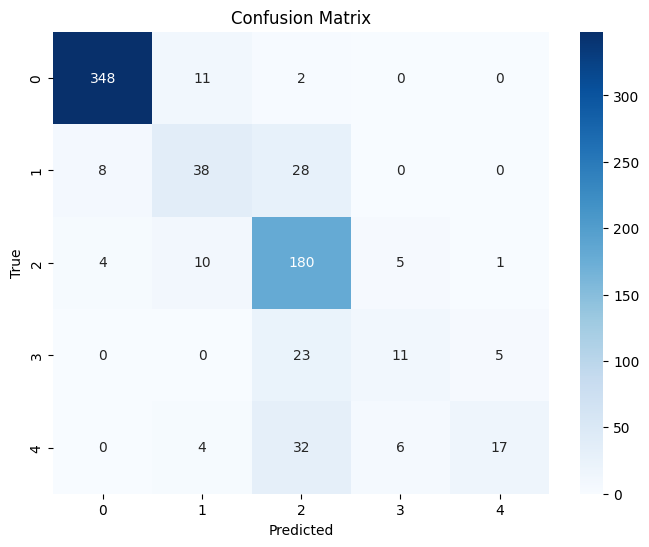

In [21]:
test_dataset = RetinopathyDataset("test_split.csv", train_images, test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

num_folds = 5
all_fold_preds = []
all_true = []
def ordinal_decode(logits):
    """Convert 4 ordinal logits → single class prediction."""
    probs = torch.sigmoid(logits)          # shape (B,4)
    passed = (probs > 0.5).sum(dim=1)      # count thresholds satisfied
    return passed                          # 0–4

for fold in range(num_folds):
    print(f"Testing fold {fold + 1}")

    # Load ordinal model
    model = OrdinalInceptionV3().to(device)
    model.load_state_dict(torch.load(f"best_modelfold{fold + 1}.pt"))
    model.eval()

    fold_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            logits = model(images)                # shape (B,4)
            preds = ordinal_decode(logits)        # shape (B,)
            fold_preds.append(preds.cpu())
            if fold == 0:
                 all_true.append(labels)

    fold_preds = torch.cat(fold_preds, dim=0)     # shape (N,)
    all_fold_preds.append(fold_preds)

#---- Ordinal Ensemble: majority vote across folds ----
stacked = torch.stack(all_fold_preds)             # shape (5, N)
ensemble_preds, _  = torch.mode(stacked, dim=0)    # majority vote

#final_preds is a vector of length N with values 0–4
final_preds = ensemble_preds
y_true = torch.cat(all_true, dim = 0)

cm = confusion_matrix(y_true, final_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
test_dataset = RetinopathyDataset("test_split.csv", train_images, test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

num_folds = 5
all_fold_preds = []
all_true = []
for fold in range(num_folds):
    print(f"Testing fold {fold + 1}")
    model = get_inception_v3_model(num_classes=5)
    model.load_state_dict(torch.load(f"best_model_fold_{fold + 1}.pt"))
    model.eval()

    fold_preds = []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            probs = F.softmax(outputs, dim=1)
            fold_preds.append(probs.cpu())

            if fold == 0:
                 all_true.append(labels)


    fold_preds = torch.cat(fold_preds, dim=0)
    all_fold_preds.append(fold_preds)

# Ensemble by averaging
stacked_preds = torch.stack(all_fold_preds)
ensemble_preds = stacked_preds.mean(dim=0)
final_preds = torch.argmax(ensemble_preds, dim=1)




Testing fold 1


/usr/local/lib/python3.12/dist-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


Testing fold 2
Testing fold 3
Testing fold 4
Testing fold 5


Test set accuracy: 0.8104
Test set QWK: 0.8669


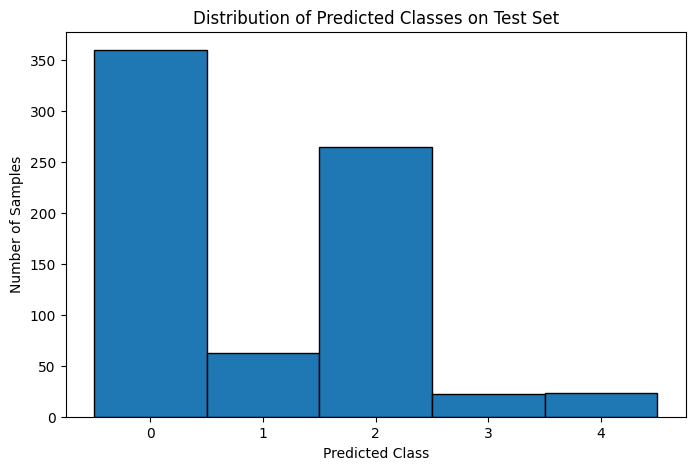

In [22]:
# Accuracy
true_labels = torch.tensor(test_df["diagnosis"].values)
accuracy = (final_preds == true_labels).sum().item() / len(true_labels)
print(f"Test set accuracy: {accuracy:.4f}")

#QWK
y_true = true_labels.numpy() if torch.is_tensor(true_labels) else true_labels
y_pred = final_preds.numpy() if torch.is_tensor(final_preds) else final_preds

qwk = cohen_kappa_score(y_true, y_pred, weights='quadratic')
print(f"Test set QWK: {qwk:.4f}")

# Distribution plot
plt.figure(figsize=(8,5))
plt.hist(final_preds.numpy(), bins=np.arange(6)-0.5, edgecolor='black')
plt.xticks(range(5))
plt.xlabel("Predicted Class")
plt.ylabel("Number of Samples")
plt.title("Distribution of Predicted Classes on Test Set")
plt.show()

#Other attempts while working on the model (You can stop running cells here):

In [ ]:
class SimpleDRCNN(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)

        # 128x128 → 64x64 → 32x32 → 16x16
        self.fc1 = nn.Linear(128 * 16 * 16, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # 64x64
        x = self.pool(F.relu(self.conv2(x))) # 32x32
        x = self.pool(F.relu(self.conv3(x))) # 16x16

        x = torch.flatten(x, 1)
        x = self.dropout(x)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
def train_one_fold(model, train_loader, val_loader, fold, epochs=3, patience=3, criterion = None):

    best_qwk = -np.inf
    wait = 0

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for imgs, labels in tqdm(train_loader, desc=f"Fold {fold + 1} Epoch {epoch+1}"):
            imgs = imgs.cuda(); labels = labels.cuda()

            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # ===== Validation & QWK =====
        model.eval()
        val_labels = []
        val_preds = []

        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs = imgs.cuda(); labels = labels.cuda()

                outputs = model(imgs)
                _, preds = torch.max(outputs, 1)

                val_labels.extend(labels.cpu().numpy())
                val_preds.extend(preds.cpu().numpy())

        qwk = qwk_score(val_labels, val_preds)
        print(f"Fold {fold + 1} Epoch {epoch+1}: QWK = {qwk:.4f}")

        # ===== Early Stopping =====
        if qwk > best_qwk:
            best_qwk = qwk
            wait = 0
            torch.save(model.state_dict(), f"best_model_fold_{fold + 1}.pt")
            print("  -> Saved new best model")
        else:
            wait += 1
            if wait >= patience:
                print("  -> Early stopping triggered!")
                break

    return best_qwk

In [ ]:
# train_transform = transforms.Compose([
#     transforms.Resize((128, 128)),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(10),
#     transforms.ToTensor(),
# ])

# val_transform = transforms.Compose([
#     transforms.Resize((128, 128)),
#     transforms.ToTensor(),
# ])

# test_transform = transforms.Compose([
#     transforms.Resize((128, 128)),
#     transforms.ToTensor(),
# ])

In [ ]:
# compute class weights
class_counts = train_df["diagnosis"].value_counts().sort_index().values
class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.sum()

class_weights = torch.tensor(class_weights, dtype=torch.float32).cuda()
criterion = nn.CrossEntropyLoss(weight=class_weights)

fold_scores = []
num_classes = 5

for fold, (train_idx, val_idx) in enumerate(skf.split(train_df, train_df["diagnosis"])):
    print(f"\n======== Fold {fold + 1} ========")
    train_loader, val_loader = get_loaders(fold)
    # Compute class weights for THIS fold only
    fold_train_df = train_df.iloc[train_idx].reset_index(drop=True)
    y = fold_train_df["diagnosis"].values
    classes = np.arange(num_classes)
    class_weights = compute_class_weight(
        class_weight="balanced",
        classes=classes,
        y=y
    )
    class_weights = torch.tensor(class_weights, dtype=torch.float32).cuda()
    print(f"Class weights for fold {fold + 1}: {class_weights.cpu().numpy()}")
    # Create weighted loss function
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    # Initialize model
    model = SimpleDRCNN(num_classes=num_classes).cuda()

    # Train one fold
    score = train_one_fold(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,      # <-- pass weighted loss
        fold=fold
    )

    fold_scores.append(score)

print("\nQWK per fold:", fold_scores)
print("Average QWK:", np.mean(fold_scores))


======== Fold 1 ========
Class weights for fold 1: [0.40571427 1.9772152  0.73333335 3.809756   2.479365  ]


Fold 1 Epoch 1: 100%|██████████| 74/74 [05:17<00:00,  4.28s/it]


Fold 1 Epoch 1: QWK = 0.4041
  -> Saved new best model


Fold 1 Epoch 2: 100%|██████████| 74/74 [05:08<00:00,  4.16s/it]


Fold 1 Epoch 2: QWK = 0.4087
  -> Saved new best model


Fold 1 Epoch 3: 100%|██████████| 74/74 [05:13<00:00,  4.23s/it]


Fold 1 Epoch 3: QWK = 0.4372
  -> Saved new best model

======== Fold 2 ========
Class weights for fold 2: [0.40571427 1.9772152  0.73333335 3.809756   2.479365  ]


Fold 2 Epoch 1: 100%|██████████| 74/74 [05:12<00:00,  4.23s/it]


Fold 2 Epoch 1: QWK = 0.4823
  -> Saved new best model


Fold 2 Epoch 2: 100%|██████████| 74/74 [05:12<00:00,  4.22s/it]


Fold 2 Epoch 2: QWK = 0.3766


Fold 2 Epoch 3: 100%|██████████| 74/74 [05:21<00:00,  4.34s/it]


Fold 2 Epoch 3: QWK = 0.3710

======== Fold 3 ========
Class weights for fold 3: [0.40571427 1.9855932  0.73333335 3.7790322  2.479365  ]


Fold 3 Epoch 1: 100%|██████████| 74/74 [05:21<00:00,  4.35s/it]


Fold 3 Epoch 1: QWK = 0.4237
  -> Saved new best model


Fold 3 Epoch 2: 100%|██████████| 74/74 [05:18<00:00,  4.30s/it]


Fold 3 Epoch 2: QWK = 0.4227


Fold 3 Epoch 3: 100%|██████████| 74/74 [05:16<00:00,  4.28s/it]


Fold 3 Epoch 3: QWK = 0.5177
  -> Saved new best model

======== Fold 4 ========
Class weights for fold 4: [0.40571427 1.9772152  0.7321875  3.809756   2.4925532 ]


Fold 4 Epoch 1: 100%|██████████| 74/74 [05:19<00:00,  4.32s/it]


Fold 4 Epoch 1: QWK = 0.3994
  -> Saved new best model


Fold 4 Epoch 2: 100%|██████████| 74/74 [05:18<00:00,  4.31s/it]


Fold 4 Epoch 2: QWK = 0.4197
  -> Saved new best model


Fold 4 Epoch 3: 100%|██████████| 74/74 [05:13<00:00,  4.23s/it]


Fold 4 Epoch 3: QWK = 0.5408
  -> Saved new best model

======== Fold 5 ========
Class weights for fold 5: [0.40553632 1.978059   0.73364633 3.811382   2.4804232 ]


Fold 5 Epoch 1: 100%|██████████| 74/74 [05:27<00:00,  4.43s/it]


Fold 5 Epoch 1: QWK = 0.3796
  -> Saved new best model


Fold 5 Epoch 2: 100%|██████████| 74/74 [05:18<00:00,  4.31s/it]


Fold 5 Epoch 2: QWK = 0.4543
  -> Saved new best model


Fold 5 Epoch 3: 100%|██████████| 74/74 [05:19<00:00,  4.31s/it]


Fold 5 Epoch 3: QWK = 0.4763
  -> Saved new best model

QWK per fold: [np.float64(0.43716105352924584), np.float64(0.4823406239264507), np.float64(0.5176886121430371), np.float64(0.5407959554856808), np.float64(0.4763381910898591)]
Average QWK: 0.4908648872348548


In [ ]:
test_dataset = RetinopathyDataset("test_split.csv", train_images, test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

num_folds = 5
num_classes = 5

all_fold_preds = []

for fold in range(num_folds):
    print(f"\n===== Processing fold {fold + 1} =====")
    # Load the trained model for this fold
    model = SimpleDRCNN(num_classes=num_classes).to(device)
    model.load_state_dict(torch.load(f"best_model_fold_{fold + 1}.pt"))
    model.eval()

    fold_preds = []
    with torch.no_grad():
        for batch_idx, (images, _) in enumerate(test_loader):
            images = images.to(device)
            outputs = model(images)
            probs = F.softmax(outputs, dim=1)  # convert logits to probabilities
            fold_preds.append(probs.cpu())

            if (batch_idx + 1) % 10 == 0 or (batch_idx + 1) == len(test_loader):
                print(f"Fold {fold + 1} - processed batch {batch_idx + 1}/{len(test_loader)}")

    fold_preds = torch.cat(fold_preds, dim=0)  # shape: [num_samples, num_classes]
    all_fold_preds.append(fold_preds)

# Stack predictions: shape [num_folds, num_samples, num_classes]
stacked_preds = torch.stack(all_fold_preds)

# Average over the folds
ensemble_preds = stacked_preds.mean(dim=0)  # shape: [num_samples, num_classes]

# Final predicted class
final_preds = torch.argmax(ensemble_preds, dim=1)


===== Processing fold 1 =====
Fold 1 - processed batch 10/23
Fold 1 - processed batch 20/23
Fold 1 - processed batch 23/23

===== Processing fold 2 =====
Fold 2 - processed batch 10/23
Fold 2 - processed batch 20/23
Fold 2 - processed batch 23/23

===== Processing fold 3 =====
Fold 3 - processed batch 10/23
Fold 3 - processed batch 20/23
Fold 3 - processed batch 23/23

===== Processing fold 4 =====
Fold 4 - processed batch 10/23
Fold 4 - processed batch 20/23
Fold 4 - processed batch 23/23

===== Processing fold 5 =====
Fold 5 - processed batch 10/23
Fold 5 - processed batch 20/23
Fold 5 - processed batch 23/23


Test set accuracy: 0.6548
Test Set QWK: 0.4429


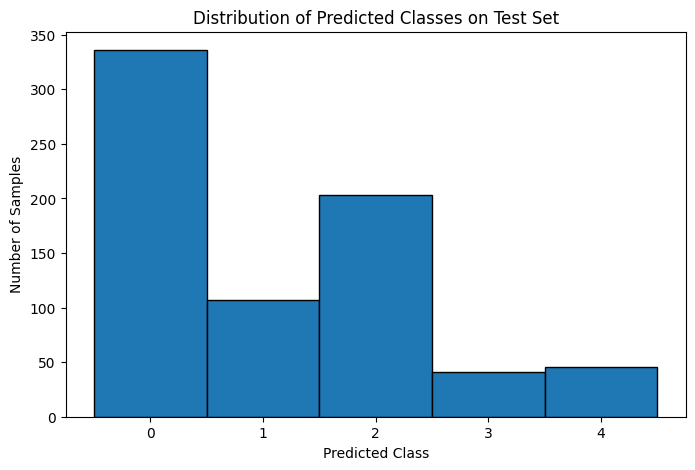

In [ ]:
true_labels = torch.tensor(test_df["diagnosis"].values)
accuracy = (final_preds == true_labels).sum().item() / len(true_labels)
print(f"Test set accuracy: {accuracy:.4f}")

# ===== Compute QWK =====
qwk = cohen_kappa_score(true_labels.numpy(), final_preds.numpy(), weights="quadratic")
print(f"Test Set QWK: {qwk:.4f}")

# final_preds is a torch tensor, convert to numpy
preds_np = final_preds.numpy()

plt.figure(figsize=(8,5))
plt.hist(preds_np, bins=np.arange(num_classes+1)-0.5, edgecolor='black')
plt.xticks(range(num_classes))  # one tick per class
plt.xlabel("Predicted Class")
plt.ylabel("Number of Samples")
plt.title("Distribution of Predicted Classes on Test Set")
plt.show()

              precision    recall  f1-score   support

           0     0.8899    0.8283    0.8580       361
           1     0.3271    0.4730    0.3867        74
           2     0.6404    0.6500    0.6452       200
           3     0.2683    0.2821    0.2750        39
           4     0.1087    0.0847    0.0952        59

    accuracy                         0.6548       733
   macro avg     0.4469    0.4636    0.4520       733
weighted avg     0.6690    0.6548    0.6599       733



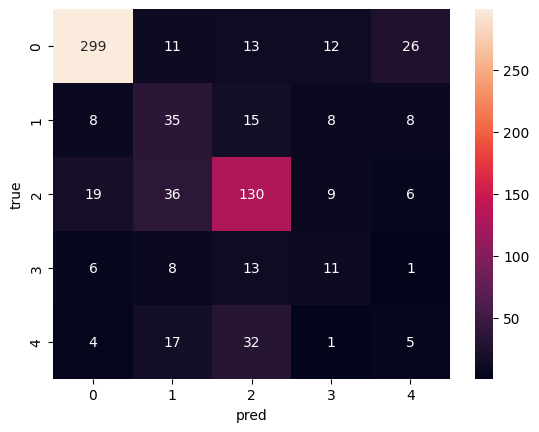

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_true = test_df["diagnosis"].values
y_pred = final_preds.numpy()

print(classification_report(y_true, y_pred, digits=4))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d'); plt.xlabel("pred"); plt.ylabel("true"); plt.show()

In [ ]:
# EPOCHS = 3
# num_folds = 5

# fold_results = {}

# for fold in range(num_folds):
#     print(f"\n===== Fold {fold + 1} / {num_folds} =====")

#     train_loader, val_loader = get_loaders(fold)

#     model = SimpleDRCNN().to(device)
#     criterion = nn.CrossEntropyLoss()
#     optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
#     best_val_acc = 0.0

#     for epoch in range(EPOCHS):
#         model.train()
#         total_loss = 0

#         for batch_idx, (images, labels) in enumerate(train_loader):
#             images = images.to(device)
#             labels = labels.to(device)

#             optimizer.zero_grad()
#             outputs = model(images)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()

#             total_loss += loss.item()

#         avg_loss = total_loss / len(train_loader)

#         # Validation
#         model.eval()
#         correct = 0
#         total = 0
#         with torch.no_grad():
#             for imgs, labels in val_loader:
#                 imgs = imgs.to(device)
#                 labels = labels.to(device)
#                 out = model(imgs)
#                 _, preds = torch.max(out, 1)
#                 correct += (preds == labels).sum().item()
#                 total += labels.size(0)

#         val_acc = correct / total
#         if val_acc > best_val_acc:
#           best_val_acc = val_acc
#           torch.save(model.state_dict(), f"fold_{fold}_best.pth")
#         print(f"Epoch {epoch+1}/{EPOCHS} | Avg Loss: {avg_loss:.4f} | Val Acc: {val_acc:.4f}")

#     # Save fold accuracy
#     fold_results[fold] = val_acc

Using device: cuda

===== Fold 1 / 5 =====
Epoch 1/3 | Avg Loss: 1.1890 | Val Acc: 0.6724
Epoch 2/3 | Avg Loss: 0.8916 | Val Acc: 0.6945
Epoch 3/3 | Avg Loss: 0.8378 | Val Acc: 0.6792

===== Fold 2 / 5 =====
Epoch 1/3 | Avg Loss: 1.1768 | Val Acc: 0.6587
Epoch 2/3 | Avg Loss: 0.9075 | Val Acc: 0.6775
Epoch 3/3 | Avg Loss: 0.8370 | Val Acc: 0.6894

===== Fold 3 / 5 =====
Epoch 1/3 | Avg Loss: 1.1946 | Val Acc: 0.6792
Epoch 2/3 | Avg Loss: 0.8900 | Val Acc: 0.7031
Epoch 3/3 | Avg Loss: 0.8460 | Val Acc: 0.6928

===== Fold 4 / 5 =====
Epoch 1/3 | Avg Loss: 1.1863 | Val Acc: 0.6741
Epoch 2/3 | Avg Loss: 0.8812 | Val Acc: 0.6962
Epoch 3/3 | Avg Loss: 0.8346 | Val Acc: 0.6758

===== Fold 5 / 5 =====
Epoch 1/3 | Avg Loss: 1.2115 | Val Acc: 0.6769
Epoch 2/3 | Avg Loss: 0.9243 | Val Acc: 0.6940
Epoch 3/3 | Avg Loss: 0.8501 | Val Acc: 0.6906


In [ ]:
# test_dataset = RetinopathyDataset("test_split.csv", train_images, test_transform)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# num_folds = 5
# num_classes = 5

# all_fold_preds = []

# for fold in range(num_folds):
#     # Load the trained model for this fold
#     model = SimpleDRCNN(num_classes=num_classes).to(device)
#     model.load_state_dict(torch.load(f"fold_{fold}_best.pth"))
#     model.eval()

#     fold_preds = []
#     with torch.no_grad():
#         for images, _ in test_loader:  # labels are ignored here
#             images = images.to(device)
#             outputs = model(images)
#             probs = F.softmax(outputs, dim=1)  # convert logits to probabilities
#             fold_preds.append(probs.cpu())

#     fold_preds = torch.cat(fold_preds, dim=0)  # shape: [num_samples, num_classes]
#     all_fold_preds.append(fold_preds)

# # Stack predictions: shape [num_folds, num_samples, num_classes]
# stacked_preds = torch.stack(all_fold_preds)

# # Average over the folds
# ensemble_preds = stacked_preds.mean(dim=0)  # shape: [num_samples, num_classes]

# # Final predicted class
# final_preds = torch.argmax(ensemble_preds, dim=1)

Test set accuracy: 0.6835


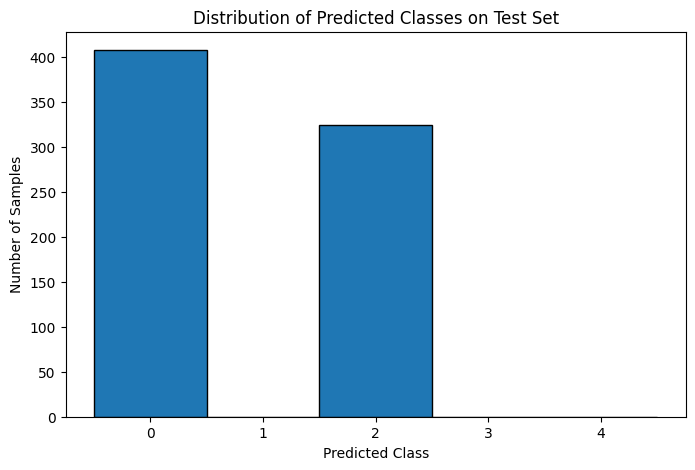

In [ ]:
# true_labels = torch.tensor(test_df["diagnosis"].values)
# accuracy = (final_preds == true_labels).sum().item() / len(true_labels)
# print(f"Test set accuracy: {accuracy:.4f}")

# # final_preds is a torch tensor, convert to numpy
# preds_np = final_preds.numpy()

# plt.figure(figsize=(8,5))
# plt.hist(preds_np, bins=np.arange(num_classes+1)-0.5, edgecolor='black')
# plt.xticks(range(num_classes))  # one tick per class
# plt.xlabel("Predicted Class")
# plt.ylabel("Number of Samples")
# plt.title("Distribution of Predicted Classes on Test Set")
# plt.show()

In [ ]:
# class TestDataset(Dataset):
#     def __init__(self, img_dir, transform=None):
#         self.img_dir = img_dir
#         self.transform = transform
#         self.filenames = sorted(os.listdir(img_dir))

#     def __len__(self):
#         return len(self.filenames)

#     def __getitem__(self, idx):
#         fname = self.filenames[idx]
#         path = os.path.join(self.img_dir, fname)

#         img = Image.open(path).convert("RGB")
#         if self.transform:
#             img = self.transform(img)

#         return img, fname

In [ ]:
# test_images = dataset_path + "/test_images"

# test_dataset = APTosTestDataset(test_images, transform=test_transform)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

In [ ]:
# device = torch.device("cuda")
# model = SimpleDRCNN().to(device)

# model.load_state_dict(torch.load("/content/drive/MyDrive/aptos_model.pth"))
# model.eval()

# print("Model loaded and ready!")

Model loaded and ready!


In [ ]:
# model.eval()
# results = []

# with torch.no_grad():
#     for imgs, fnames in test_loader:
#         imgs = imgs.to(device)
#         outputs = model(imgs)

#         preds = outputs.argmax(dim=1).cpu().tolist()

#         for fname, pred in zip(fnames, preds):
#             results.append((fname, pred))

# df = pd.DataFrame(results, columns=["id_code", "diagnosis"])
# df.to_csv("/content/drive/MyDrive/aptos_predictions.csv", index=False)

# print("Saved predictions to aptos_predictions.csv!")

Saved predictions to aptos_predictions.csv!


In [ ]:
# from pydrive2.auth import GoogleAuth, ServiceAccountCredentials
# from pydrive2.drive import GoogleDrive

# gauth = GoogleAuth()

# # Prevent PyDrive2 from trying to read client_secrets.json
# gauth.settings = {
#     'client_config_backend': 'service',
#     'service_config': {
#         'client_json_file_path': 'acquired-talent-479707-u9-7a6249ae19df.json'  # your file
#     }
# }

# gauth.credentials = ServiceAccountCredentials.from_json_keyfile_name(
#     'acquired-talent-479707-u9-7a6249ae19df.json',
#     scopes=['https://www.googleapis.com/auth/drive']
# )

# gauth.Authorize()

# drive = GoogleDrive(gauth)
# print("Service account authenticated.")

Service account authenticated.


In [ ]:
# folder_id = "1HN1QyKm6RVPwEMVfwFO-pNDbrlpp3WNf"

# # List files
# file_list = drive.ListFile({'q': f"'{folder_id}' in parents"}).GetList()

# for f in file_list:
#     print(f['title'], f['id'])

train_images 1iRGGeaZs7Cl6c4x9rMPL1CKuDyja19_t
test_images 1XO9QC-0YHH16cc25j_QO3A1KhKq-mAhV
train.csv 1UT6Tky1MQcvvHQ7mS3ctJQ-l1aG_wV6Y
test.csv 1E2ulvO1HPkR9NCM1UGxewr1JuLkZNCo1
sample_submission.csv 1IVABRmibzIu-2uivjTmeK5_B4uP3p5HH


In [ ]:
# # Download dataset
# def download_folder_recursively(folder_id, dest_path):
#     os.makedirs(dest_path, exist_ok=True)

#     file_list = drive.ListFile({'q': f"'{folder_id}' in parents"}).GetList()

#     for f in file_list:
#         fname = f['title']
#         fid = f['id']

#         if f['mimeType'] == 'application/vnd.google-apps.folder':
#             print(f"[Folder] {fname}")
#             download_folder_recursively(fid, os.path.join(dest_path, fname))
#         else:
#             print(f"[File] {fname}")
#             out_path = os.path.join(dest_path, fname)
#             f.GetContentFile(out_path)

# # Download your whole dataset folder:
# download_folder_recursively(
#     "1HN1QyKm6RVPwEMVfwFO-pNDbrlpp3WNf",
#     "aptos_dataset"
# )

[Folder] train_images
[File] ff52392372d3.png
[File] ffa47f6a7bf4.png
[File] ff8a0b45c789.png
[File] ff4cd992667b.png
[File] ffcf7b45f213.png
[File] ff59d44a70a7.png
[File] ffec9a18a3ce.png
[File] ff631653374e.png
[File] ffc04fed30e6.png
[File] ff77e8e5b5f3.png
[File] ffd97f8cd5aa.png
[File] fe0fc67c7980.png
[File] fe674c2f73f5.png
[File] fe0e2dee1834.png
[File] fefded6bf135.png
[File] fdbc252813b1.png
[File] fd62bd0db4f1.png
[File] fe06dad6851c.png
[File] fda39982a810.png
[File] fdc685055659.png
[File] ff1e940105f9.png
[File] ff0740cb484a.png
[File] fecf4c5ae84b.png
[File] ff03f74667df.png
[File] fd87b6b2e664.png
[File] ff4832d55461.png
[File] fea14b3d44b0.png
[File] fe37f4492920.png
[File] fe3b0e50be78.png
[File] ff4955e76894.png
[File] fe3f62695b2d.png
[File] fe2df69676cf.png
[File] ff344e5c9341.png
[File] febfb20dc311.png
[File] fdd534271f3d.png
[File] fdd18ccbbdc5.png
[File] fed5bb685832.png
[File] fce73678f650.png
[File] fcc32dffd24d.png
[File] fc782722a50c.png
[File] fb88783de05

InvalidConfigError: Insufficient service config in settings

Missing: client_user_email key.

In [ ]:
# train_transform = transforms.Compose([
#     transforms.Resize((128, 128)),
#     transforms.RandomHorizontalFlip(p=0.5),
#     transforms.ToTensor(),
# ])

# test_transform = transforms.Compose([
#     transforms.Resize((128, 128)),
#     transforms.ToTensor(),
# ])

In [ ]:
# class RetinopathyDataset(Dataset):
#     def __init__(self, df, img_dir, transform=None, has_labels=True):
#         self.df = df
#         self.img_dir = img_dir
#         self.transform = transform
#         self.has_labels = has_labels

#     def __len__(self):
#         return len(self.df)

#     def __getitem__(self, idx):
#         row = self.df.iloc[idx]
#         img_name = row["id_code"] + ".png"
#         img_path = os.path.join(self.img_dir, img_name)

#         img = Image.open(img_path).convert("RGB")

#         if self.transform:
#             img = self.transform(img)

#         if self.has_labels:
#             return img, int(row["diagnosis"])
#         return img

In [ ]:
# class SimpleDRCNN(nn.Module):
#     def __init__(self, num_classes=5):
#         super(SimpleDRCNN, self).__init__()

#         self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
#         self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
#         self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

#         self.pool = nn.MaxPool2d(2, 2)
#         self.dropout = nn.Dropout(0.3)

#         # 128 -> 64 -> 32 -> 16
#         self.fc1 = nn.Linear(128 * 16 * 16, 512)
#         self.fc2 = nn.Linear(512, num_classes)

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = self.pool(F.relu(self.conv3(x)))
#         x = self.dropout(x)
#         x = torch.flatten(x, 1)
#         x = F.relu(self.fc1(x))
#         x = self.dropout(x)
#         return self.fc2(x)

In [ ]:
# DATA_DIR = "/content/aptos2019-blindness-detection"

# train_csv_path = os.path.join(DATA_DIR, "train.csv")
# test_csv_path = os.path.join(DATA_DIR, "test.csv")
# train_img_dir = os.path.join(DATA_DIR, "train_images")
# test_img_dir = os.path.join(DATA_DIR, "test_images")
# train_df = pd.read_csv(train_csv_path)
# test_df = pd.read_csv(test_csv_path)
# print(train_df.head())
# print(test_df.head())

FileNotFoundError: [Errno 2] No such file or directory: '/content/aptos2019-blindness-detection/train.csv'

In [ ]:
# train_csv = "/content/train.csv"
# train_img_dir = "/content/train_images"

# train_df = pd.read_csv(train_csv)

# train_dataset = RetinopathyDataset(train_df, train_img_dir, transform=train_transform)

# train_loader = DataLoader(
#     train_dataset,
#     batch_size=64,          # GPU-friendly
#     shuffle=True,
#     num_workers=2,          # Great for Colab
#     pin_memory=True
# )

In [ ]:
# model = SimpleDRCNN().to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# scaler = torch.cuda.amp.GradScaler()

# epochs = 5

# for epoch in range(epochs):
#     model.train()
#     running_loss = 0.0

#     pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

#     for imgs, labels in pbar:
#         imgs = imgs.to(device, non_blocking=True)
#         labels = labels.to(device, non_blocking=True)

#         optimizer.zero_grad()

#         with torch.cuda.amp.autocast():
#             outputs = model(imgs)
#             loss = criterion(outputs, labels)

#         scaler.scale(loss).backward()
#         scaler.step(optimizer)
#         scaler.update()

#         running_loss += loss.item()
#         pbar.set_postfix(loss=running_loss / len(train_loader))

# print("Training finished!")